# Imports

In [1]:
!pip install adabound

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.preprocessing import image
import pandas as pd
import numpy as np
import cv2
import imageio
from PIL import Image
from sklearn.utils import class_weight
import numpy as np
from keras import layers, Input, utils
from keras.models import Model

# Global variables


In [4]:
BATCH_SIZE = 128
TOT_DATA = 11199
EPOCHS = 30
VALIDATION_SPLIT = 0.3
directory = "../Rub7/light"
tot_train = TOT_DATA*(1-VALIDATION_SPLIT)
tot_val = TOT_DATA*VALIDATION_SPLIT
img_dim = (128,128)


#Creating train and val set

In [5]:
image_generator = image.ImageDataGenerator(rescale = 1. /255, validation_split = VALIDATION_SPLIT, preprocessing_function = None )
train_data = image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory = directory, 
                                                 subset = "training", 
                                                 shuffle = True, 
                                                 target_size = (128,128), 
                                                 class_mode = "categorical")
validation_data = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                      directory = directory,
                                                      subset = "validation",
                                                      shuffle = True,
                                                      target_size = (128,128),
                                                      class_mode = "categorical")
print(train_data.classes)

Found 9101 images belonging to 3 classes.
Found 3899 images belonging to 3 classes.
[0 0 0 ... 2 2 2]


##Classes weights

In [6]:
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_data.classes), 
            train_data.classes)
weight = {i : class_weights[i] for i in range(3)}
print(weight)

{0: 0.6466993533717047, 1: 1.3561317240351662, 2: 1.3960730173339468}


C:\Users\USER\anaconda3\envs\tensorflow-cpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


#Model

In [7]:
def classification_model(x, input_layer_dim):
  dim = input_layer_dim
  i = 0
  while dim > 3:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    #if i%2 == 0:
    #  x = layers.BatchNormalization()(x)
    dim /= 4
    i-=-1
  return layers.Dense(3, activation="softmax")(x)

In [8]:
#inception v3 --> https://keras.io/api/applications/inceptionv3/
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.utils import plot_model

In [9]:
input_img_shape = Input(shape=(*img_dim, 3), name="img")
print(input_img_shape)

inception_model = InceptionV3(input_shape = (128,128,3),
                               include_top = False, # whether to include the fully-connected layer at the top, as the last layer of the network. Default to True.
                               #weights = 'imagenet' #weights from imageNet (default)
                               pooling = 'avg', # Optional pooling mode for feature extraction: None (default), avg, max
                               #classes = 3 #optional number of classes to classify images into
                               ) 



KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='img'), name='img', description="created by layer 'img'")


In [10]:
output_x = inception_model.output

output_x = classification_model(output_x, output_x.shape[1])

final_inception_model = Model(inputs = inception_model.input, outputs = output_x)

plot_model(final_inception_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [11]:
from adabound import AdaBound # https://github.com/Luolc/AdaBound
lr = 0.003

final_inception_model.compile(optimizer = 'adam',#AdaBound(lr=lr),
                        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics = ['accuracy'])

history = final_inception_model.fit(train_data,
                              epochs=EPOCHS,
                              class_weight=weight, 
                              steps_per_epoch=tot_train // BATCH_SIZE,
                              validation_data=validation_data,
                              validation_steps=tot_val // BATCH_SIZE)

Epoch 1/30
61/61 [==============================] - 722s 12s/step - loss: 1.1269 - accuracy: 0.3040 - val_loss: 1.0985 - val_accuracy: 0.2413
Epoch 2/30
61/61 [==============================] - 693s 11s/step - loss: 1.0928 - accuracy: 0.2692 - val_loss: 1.0897 - val_accuracy: 0.2602
Epoch 3/30
61/61 [==============================] - 708s 12s/step - loss: 1.0467 - accuracy: 0.3335 - val_loss: 31.9462 - val_accuracy: 0.2623
Epoch 4/30
61/61 [==============================] - 680s 11s/step - loss: 0.7233 - accuracy: 0.6768 - val_loss: 7.0373 - val_accuracy: 0.6091
Epoch 5/30
61/61 [==============================] - 1042s 17s/step - loss: 0.5608 - accuracy: 0.7691 - val_loss: 44.9283 - val_accuracy: 0.4961
Epoch 6/30
61/61 [==============================] - 1366s 22s/step - loss: 0.5115 - accuracy: 0.8057 - val_loss: 1.3258 - val_accuracy: 0.8492
Epoch 7/30
61/61 [==============================] - 1333s 22s/step - loss: 0.5036 - accuracy: 0.7943 - val_loss: 0.9896 - val_accuracy: 0.7163
E

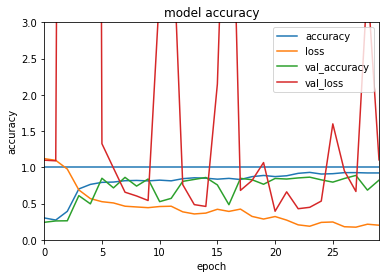

In [12]:
plt.plot(history.history['accuracy'])  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_accuracy'])  
plt.plot(history.history['val_loss']) 
plt.hlines(1, 0, EPOCHS)
plt.axis([0,EPOCHS-1, 0, 3]) 
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['accuracy', 'loss','val_accuracy', 'val_loss'], loc='best') 

## Save Model


In [13]:
import os

save_path = "../save/light/inception_model"

if not os.path.exists(save_path) :
  os.makedirs(save_path)

final_inception_model.save(save_path)

INFO:tensorflow:Assets written to: ../save/light/inception_model\assets


# Orientation


In [14]:
directory = "../Rub7/orientation"

In [15]:
image_generator = image.ImageDataGenerator(rescale = 1. /255, validation_split = VALIDATION_SPLIT, preprocessing_function = None )
train_data = image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory = directory, 
                                                 subset = "training", 
                                                 shuffle = True, 
                                                 target_size = (128,128), 
                                                 class_mode = "categorical")
validation_data = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                      directory = directory,
                                                      subset = "validation",
                                                      shuffle = True,
                                                      target_size = (128,128),
                                                      class_mode = "categorical")
print(train_data.classes)

Found 7841 images belonging to 3 classes.
Found 3358 images belonging to 3 classes.
[0 0 0 ... 2 2 2]


In [16]:
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_data.classes), 
            train_data.classes)
weight = {i : class_weights[i] for i in range(3)}
print(weight)

{0: 0.5796555038072004, 1: 1.522228693457581, 2: 1.6183694530443757}


C:\Users\USER\anaconda3\envs\tensorflow-cpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [17]:
inception_model = InceptionV3(input_shape = (128,128,3),
                               include_top = False, # whether to include the fully-connected layer at the top, as the last layer of the network. Default to True.
                               #weights = 'imagenet' #weights from imageNet (default)
                               pooling = 'avg', # Optional pooling mode for feature extraction: None (default), avg, max
                               #classes = 3 #optional number of classes to classify images into
                               )

output_x = inception_model.output

output_x = classification_model(output_x, output_x.shape[1])

final_inception_model = Model(inputs = inception_model.input, outputs = output_x)

In [18]:
final_inception_model.compile(optimizer = 'adam',#AdaBound(lr=lr),
                        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics = ['accuracy'])

history = final_inception_model.fit(train_data,
                              epochs=EPOCHS,
                              class_weight=weight, 
                              steps_per_epoch=tot_train // BATCH_SIZE,
                              validation_data=validation_data,
                              validation_steps=tot_val // BATCH_SIZE)

Epoch 1/30
61/61 [==============================] - 770s 13s/step - loss: 0.8704 - accuracy: 0.4045 - val_loss: 46.2551 - val_accuracy: 0.2194
Epoch 2/30
61/61 [==============================] - 724s 12s/step - loss: 0.6053 - accuracy: 0.6556 - val_loss: 40.8990 - val_accuracy: 0.2332
Epoch 3/30
61/61 [==============================] - 718s 12s/step - loss: 0.4951 - accuracy: 0.7904 - val_loss: 2.6324 - val_accuracy: 0.5553
Epoch 4/30
61/61 [==============================] - 749s 12s/step - loss: 0.4276 - accuracy: 0.8471 - val_loss: 2.4758 - val_accuracy: 0.6965
Epoch 5/30
61/61 [==============================] - 735s 12s/step - loss: 0.3995 - accuracy: 0.8825 - val_loss: 433.5040 - val_accuracy: 0.6656
Epoch 6/30
61/61 [==============================] - 758s 12s/step - loss: 0.5375 - accuracy: 0.7604 - val_loss: 2.5637 - val_accuracy: 0.6508
Epoch 7/30
61/61 [==============================] - 749s 12s/step - loss: 0.4518 - accuracy: 0.8295 - val_loss: 1.8487 - val_accuracy: 0.3290
Ep

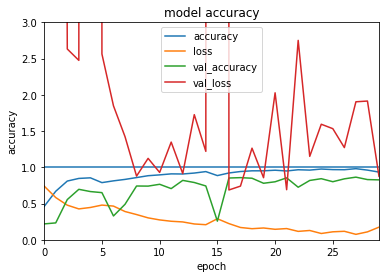

In [19]:
plt.plot(history.history['accuracy'])  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_accuracy'])  
plt.plot(history.history['val_loss']) 
plt.hlines(1, 0, EPOCHS)
plt.axis([0,EPOCHS-1, 0, 3]) 
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['accuracy', 'loss','val_accuracy', 'val_loss'], loc='best')

In [23]:
import os

save_path = "../save/orientation/inception_model"

if not os.path.exists(save_path) :
  os.makedirs(save_path)

final_inception_model.save(save_path)

INFO:tensorflow:Assets written to: ../save/orientation/inception_model\assets


In [22]:
print(weight)

{0: 0.5796555038072004, 1: 1.522228693457581, 2: 1.6183694530443757}
